# rule based feature 추출

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

## Anode

In [2]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Normal

[PosixPath('../data/230507/Anode/Normal/1.csv'),
 PosixPath('../data/230507/Anode/Normal/10.csv'),
 PosixPath('../data/230507/Anode/Normal/11.csv'),
 PosixPath('../data/230507/Anode/Normal/12.csv'),
 PosixPath('../data/230507/Anode/Normal/14.csv'),
 PosixPath('../data/230507/Anode/Normal/15.csv'),
 PosixPath('../data/230507/Anode/Normal/16.csv'),
 PosixPath('../data/230507/Anode/Normal/17.csv'),
 PosixPath('../data/230507/Anode/Normal/18.csv'),
 PosixPath('../data/230507/Anode/Normal/19.csv'),
 PosixPath('../data/230507/Anode/Normal/2.csv'),
 PosixPath('../data/230507/Anode/Normal/20.csv'),
 PosixPath('../data/230507/Anode/Normal/20230412_110032_0__03_Total.csv'),
 PosixPath('../data/230507/Anode/Normal/21.csv'),
 PosixPath('../data/230507/Anode/Normal/22.csv'),
 PosixPath('../data/230507/Anode/Normal/23.csv'),
 PosixPath('../data/230507/Anode/Normal/24.csv'),
 PosixPath('../data/230507/Anode/Normal/25.csv'),
 PosixPath('../data/230507/Anode/Normal/26.csv'),
 PosixPath('../data/230507/

In [3]:
len(Anode_Normal)

35

In [4]:
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])
Anode_Abnormal

[PosixPath('../data/230507/Anode/Abnormal/20230412_105553_0__01_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_105804_0__02_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110249_0__04_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110451_0__05_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110735_0__06_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110928_0__07_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111152_0__08_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111719_0__09_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111935_0__10_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112153_0__11_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112415_0__12_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112642_0__13_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112855_0__14_Total.csv'),

In [5]:
len(Anode_Abnormal)

18

In [6]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [7]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

### Train, Test 생성

In [8]:
Anode_Normal_df = pd.DataFrame()
for i, c in enumerate(Anode_Normal):
    extractor = ExtractFeatures(str(c))
    extracted_data = extractor.extract(extractor.data, verbose=False)
    extracted_data_ = [ {**extracted_data[d]["lo_features"], **extracted_data[d]["br_features"], 
                         **extracted_data[d]["nir_features"], **extracted_data[d]["vis_features"], 'label' : 0 } 
                       for d in extracted_data ]
    Anode_Normal_df = pd.concat([Anode_Normal_df, pd.DataFrame(extracted_data_)])

warning index: 40140
error index: 40239
warning index: 40690
error index: 40789
warning index: 41239
error index: 41338
warning index: 41788
error index: 41887
warning index: 42337
error index: 42436
warning index: 42886
error index: 42985
warning index: 43436
error index: 43535
warning index: 43986
error index: 44085
warning index: 44535
error index: 44634
warning index: 45085
error index: 45184
warning index: 45634
error index: 45733
warning index: 46184
error index: 46283
warning index: 46733
error index: 46832
warning index: 47282
error index: 47381
warning index: 47832
error index: 47931
warning index: 48381
error index: 48480
warning index: 48930
error index: 49029
warning index: 49479
error index: 49578
warning index: 50028
error index: 50127
warning index: 50577
error index: 50676
warning index: 51127
error index: 51226
warning index: 51676
error index: 51775
warning index: 52226
error index: 52325
warning index: 52775
error index: 52874
warning index: 53325
error index: 53424


In [9]:
Anode_Abnormal_df = pd.DataFrame()
for i, c in enumerate(Anode_Abnormal):
    extractor = ExtractFeatures(str(c))
    extracted_data = extractor.extract(extractor.data, verbose=False)
    extracted_data_ = [ {**extracted_data[d]["lo_features"], **extracted_data[d]["br_features"], 
                         **extracted_data[d]["nir_features"], **extracted_data[d]["vis_features"], 'label' : 1 } 
                       for d in extracted_data ]
    Anode_Abnormal_df = pd.concat([Anode_Abnormal_df, pd.DataFrame(extracted_data_)])

warning index: 43496
error index: 43594
warning index: 43946
error index: 44044
warning index: 44394
error index: 44493
warning index: 44844
error index: 44942
warning index: 45293
error index: 45391
warning index: 45742
error index: 45840
warning index: 46192
error index: 46290
warning index: 46642
error index: 46740
warning index: 47091
error index: 47189
warning index: 47541
error index: 47639
warning index: 47989
warning index: 47990
error index: 48088
warning index: 48439
warning index: 48440
error index: 48538
warning index: 48889
error index: 48987
warning index: 49338
error index: 49436
warning index: 49788
error index: 49886
warning index: 50236
warning index: 50237
error index: 50335
warning index: 50686
error index: 50784
warning index: 51135
error index: 51233
warning index: 51584
error index: 51682
warning index: 52032
warning index: 52033
error index: 52131
error index: 52581
warning index: 52932
error index: 53030
warning index: 53382
error index: 53480
warning index: 53

In [10]:
split_rate = 0.8
train_index = int(len(Anode_Normal)*split_rate) * 54
Anode_Train = Anode_Normal_df.iloc[:train_index]
Anode_Test = pd.concat([Anode_Normal_df.iloc[train_index:], Anode_Abnormal_df])

In [11]:
Anode_Train.head(5)

,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,3.292055,2.932646,3.344641,0.043745,100,322.669751,5.297992,16,4.150539,0.380110,...,0.0,1,0.063747,10.542135,0.215438,26,0.0,2,0.147684,0
1,3.293162,2.964636,3.332362,0.039373,100,323.246546,7.750054,17,6.589675,0.278433,...,0.0,3,0.303926,8.392543,0.187928,33,0.0,4,0.359773,0
2,3.294754,2.979177,3.333655,0.037731,100,323.408437,7.974320,20,6.782272,0.272605,...,0.0,2,0.141417,12.545466,0.214143,28,0.0,3,0.328167,0
3,3.292459,2.942340,3.333978,0.042657,100,323.347689,8.540802,19,7.442791,0.336719,...,0.0,3,0.224268,12.438227,0.205081,30,0.0,3,0.284476,0
4,3.293290,2.975946,3.344965,0.041039,100,323.456910,8.267094,21,6.920903,0.297214,...,0.0,4,0.268263,8.251067,0.174658,32,0.0,3,0.266351,0


In [12]:
Anode_Test.head(5)

,lo_height_mean,lo_height_min,lo_height_peak,lo_height_std,lo_fwhm,lo_area,br_peak,br_peak_time,br_diff_peak,nir_peak,...,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,vis_peak,vis_reach_time,vis_over_area,vis_extra_time,vis_extra_area,label
0,3.290994,3.097444,3.333009,0.028340,100,321.593071,8.588952,21,7.442468,0.680930,...,0.0,54,6.117315,15.737818,0.235827,46,0.0,4,0.397965,0
1,3.290126,3.110692,3.318144,0.026868,100,321.858688,5.778516,18,4.636879,0.288148,...,0.0,3,0.254707,11.551690,0.195695,25,0.0,4,0.324496,0
2,3.288218,3.105522,3.330100,0.030732,100,321.678053,7.008748,19,5.899426,0.325710,...,0.0,6,0.376003,9.409993,0.212201,49,0.0,3,0.260202,0
3,3.288699,3.086134,3.348196,0.032648,100,321.717472,7.395882,18,6.268787,0.478548,...,0.0,5,0.381229,12.428924,0.167214,27,0.0,4,0.366570,0
4,3.291419,3.128142,3.344641,0.028221,100,322.006359,8.315244,21,7.084418,0.341576,...,0.0,6,0.453718,11.017516,0.187280,31,0.0,4,0.352978,0


### Isolation Forest

In [13]:
import seaborn as sns

class modelling_nir:
    def __init__(self, model, dataset, feature_name : str, **kwargs):
        """
        Fit and run inference on model & Get evaluation Metrics
        :param model
            Model
        :dataset: tuple
            train and test datset
        :feature_name: str
            Name of the feature to be used
        """

        self.train_x, self.train_y, self.test_x, self.test_y = (dataset[0][feature_name].values.reshape(-1,1), 
                                                                dataset[1], 
                                                                dataset[2][[feature_name]].values.reshape(-1,1), 
                                                                dataset[3])
        self.model = model(**kwargs)

        self.threshold = None
        self.feature_name = feature_name

    def fit(self):
        """
        Fit Model
        :return: None
        """
        
        self.model.fit(self.train_x)
        
        print("model Fitted")
        
        pred = self.model.predict(self.test_x)
        self.pred = np.where(pred==1, 0, 1)
        
        self.anomaly_score = self.model.score_samples(self.test_x)

        print("Inference Completed")

    def get_confusion_mat(self):
        """
        Get confusion Matrix
        :return: tuple
            Confusion Matrix
        """
        
        tn, fp, fn, tp = confusion_matrix(self.test_y, self.pred).ravel()

        self.confusion_mat = (tn, fp, fn, tp)

        print(f'Confusion Matrix: {self.confusion_mat}')

        sns.heatmap(np.array(self.confusion_mat).reshape(2,2),
                    annot = True,
                    cmap = 'Blues',
                    fmt=',d'
                    )
        
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix ' + self.feature_name)

        plt.show()

        return self.confusion_mat

    def get_metrics(self):

        """
        Get model evaluation metrics
        :return: dict
        """

        (f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-self.anomaly_score, 
                                                                  np.array(self.test_y), 
                                                                  start=min(-self.anomaly_score), 
                                                                  end=max(-self.anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
        
        print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        self.threshold = threshold

        metric = {
                'AUROC' : AUROC, 'F1 ' : f1,
                'Precision' : precision, 'Recall' : recall
                }

        return metric

    def bead_count(self):
        """
        Prediciton result for each beads
        :return: list
        """

        bead_counter = []
        for i in range(len(self.pred)//54):
            bead_counter.append(dict(Counter(self.pred[i*54: (i+1)*54])))

        print(bead_counter)

        self.bead_counter = bead_counter
        
        return bead_counter

    def plot_result(self):
        """
        Plot Anomaly Detection Prediction Result
        """

        # Test set Prediction Result
        
        fig = plt.figure(figsize=(12, 4))
        plt.plot(self.pred, label='pred')
        plt.plot(np.array(self.test_y), label='Ground Truth')
        plt.title('Anomaly Detection Result '+ self.feature_name)
        plt.legend()
        plt.show()

        check_graph(self.pred, np.array(self.test_y))
        plt.title('Anomaly Detection Result '+ self.feature_name)

        plt.show()

        # Anomaly Score with best-threshold

        if not self.threshold:
            raise NotImplementedError("Please Search best-threshold first")
        
        check_graph(-self.anomaly_score, np.array(self.test_y), threshold=self.threshold)

        plt.title('Anomaly Score with Threshold '+ self.feature_name)
        plt.show()

In [20]:
selected_features = list(Anode_Train.columns[9:15]) + ['lo_height_mean', 'lo_area', 'vis_peak']

print(selected_features)

Anode_Train_X = Anode_Train[selected_features].reset_index(drop=True)
Anode_Train_y = Anode_Train['label']
Anode_Test_X = Anode_Test[selected_features].reset_index(drop=True)
Anode_Test_y = Anode_Test['label']

['nir_peak', 'nir_reach_time', 'nir_over_area', 'nir_extra_time', 'nir_extra_area', 'nir_sum_area', 'lo_height_mean', 'lo_area', 'vis_peak']


In [21]:
model = IsolationForest
dataset = (Anode_Train_X, Anode_Train_y, 
           Anode_Test_X, Anode_Test_y)

nir_peak
model Fitted
Inference Completed
Confusion Matrix: (321, 57, 631, 341)


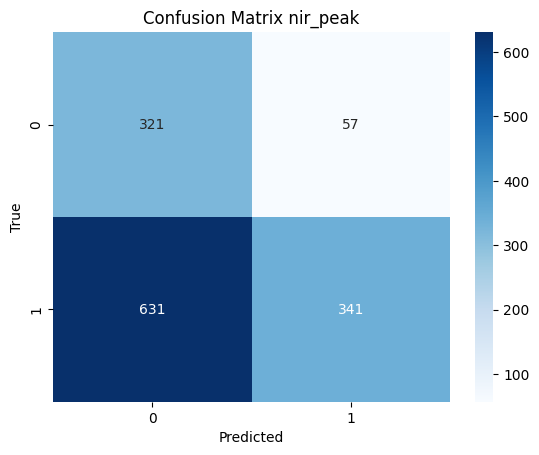

AUROC: 0.6212, F1: 0.8367, Precision: 0.7198, Recall: 0.9990
[{1: 14, 0: 40}, {1: 9, 0: 45}, {1: 8, 0: 46}, {0: 45, 1: 9}, {0: 49, 1: 5}, {0: 47, 1: 7}, {0: 49, 1: 5}, {1: 54}, {0: 13, 1: 41}, {0: 43, 1: 11}, {0: 32, 1: 22}, {0: 44, 1: 10}, {1: 10, 0: 44}, {0: 38, 1: 16}, {1: 9, 0: 45}, {0: 37, 1: 17}, {0: 39, 1: 15}, {0: 42, 1: 12}, {1: 4, 0: 50}, {0: 44, 1: 10}, {1: 26, 0: 28}, {1: 54}, {0: 38, 1: 16}, {0: 45, 1: 9}, {0: 49, 1: 5}]


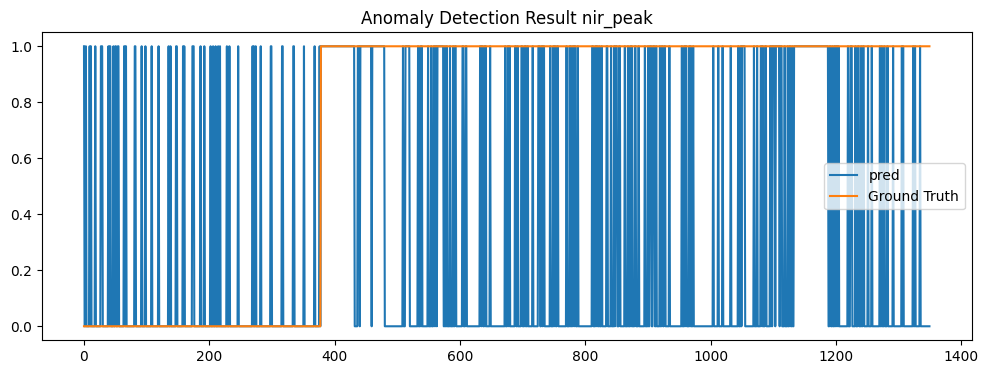

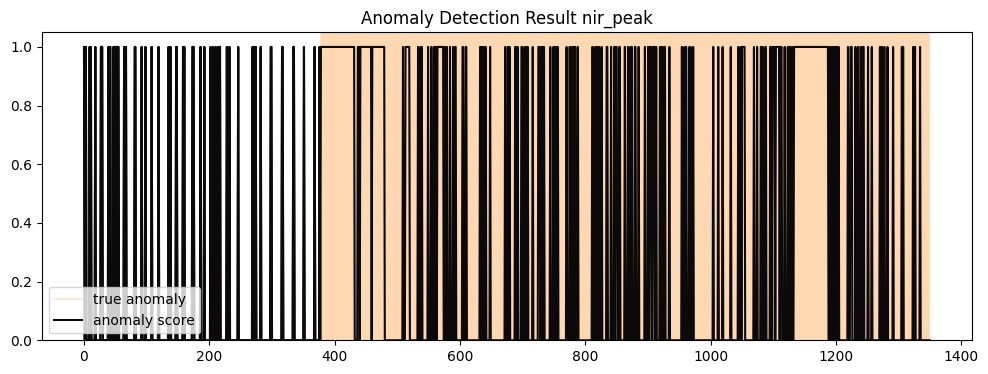

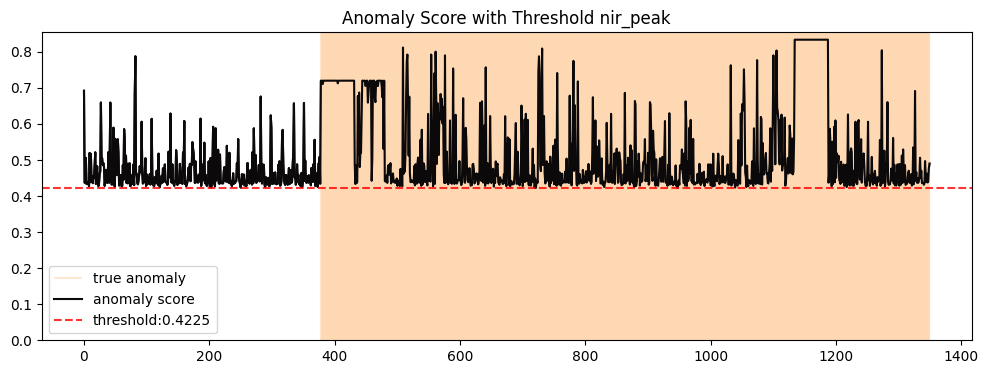

nir_reach_time
model Fitted
Inference Completed
Confusion Matrix: (272, 106, 327, 645)


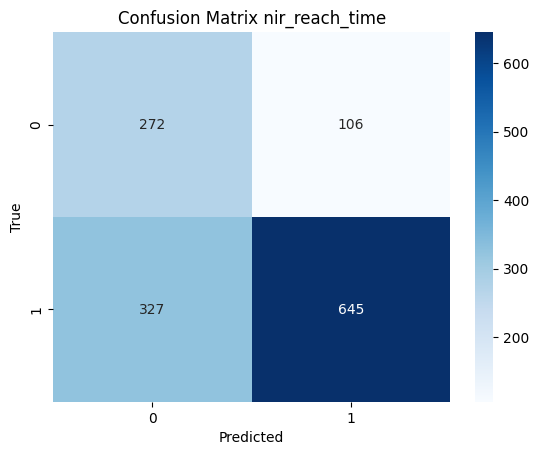

AUROC: 0.7505, F1: 0.8360, Precision: 0.7270, Recall: 0.9835
[{0: 38, 1: 16}, {1: 18, 0: 36}, {1: 8, 0: 46}, {0: 35, 1: 19}, {0: 39, 1: 15}, {1: 18, 0: 36}, {1: 12, 0: 42}, {1: 50, 0: 4}, {0: 20, 1: 34}, {1: 30, 0: 24}, {0: 20, 1: 34}, {1: 17, 0: 37}, {1: 12, 0: 42}, {1: 20, 0: 34}, {1: 33, 0: 21}, {1: 51, 0: 3}, {1: 54}, {1: 53, 0: 1}, {1: 53, 0: 1}, {1: 52, 0: 2}, {0: 7, 1: 47}, {1: 41, 0: 13}, {0: 20, 1: 34}, {0: 41, 1: 13}, {0: 37, 1: 17}]


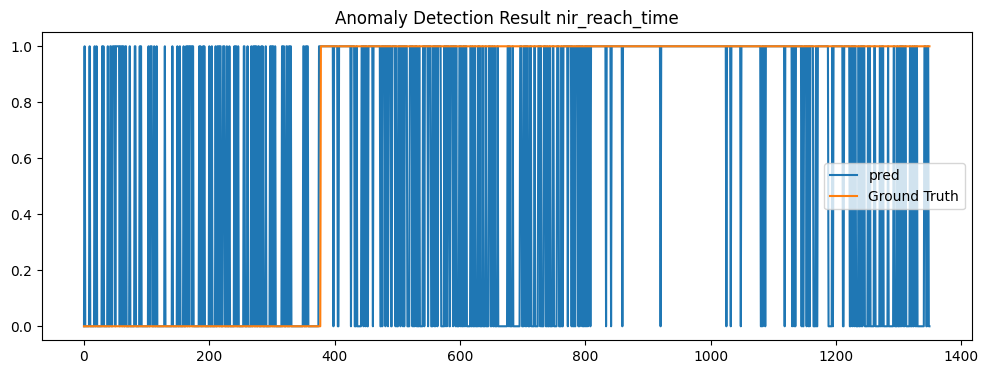

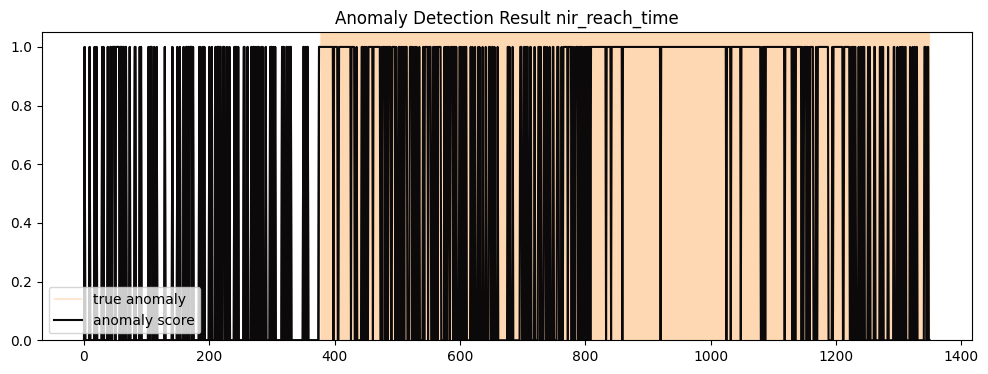

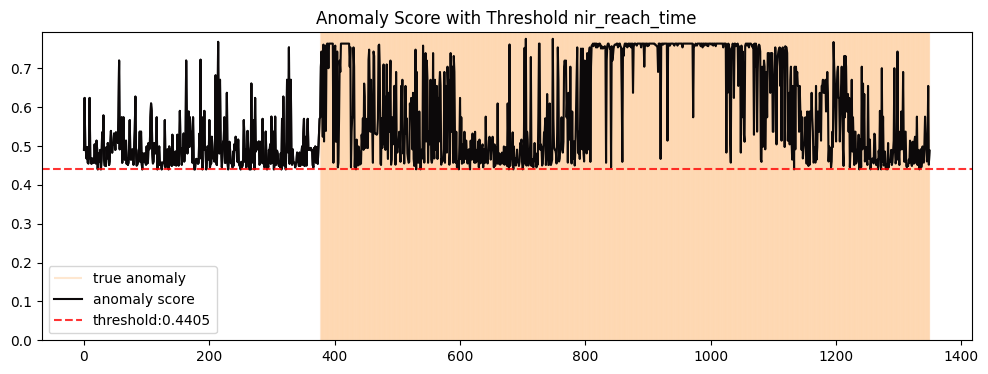

nir_over_area
model Fitted
Inference Completed
Confusion Matrix: (378, 0, 918, 54)


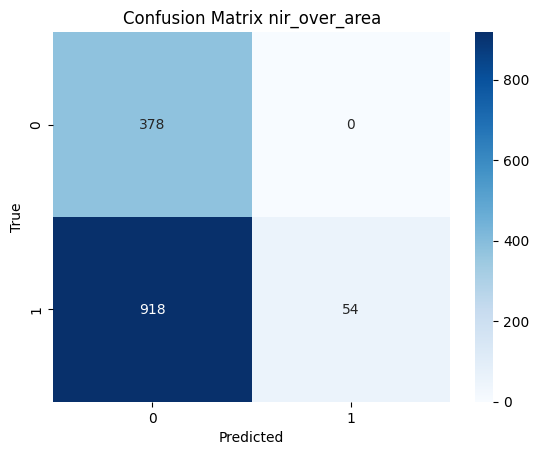

AUROC: 0.5278, F1: 0.1053, Precision: 1.0000, Recall: 0.0556
[{0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {0: 54}, {1: 54}, {0: 54}, {0: 54}, {0: 54}]


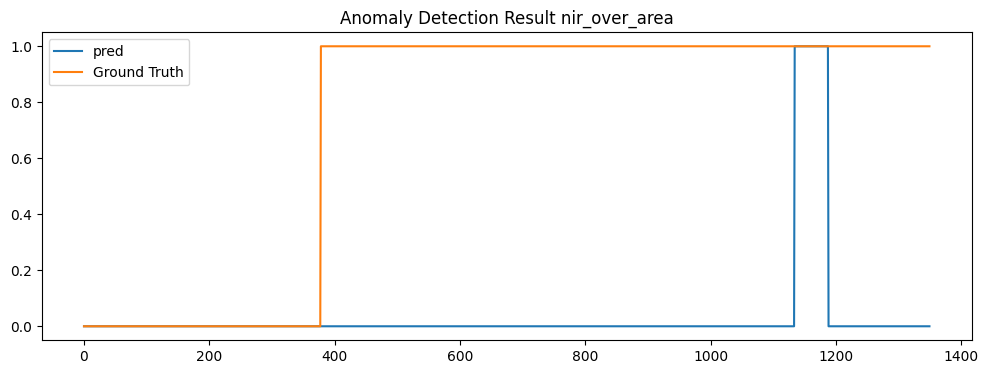

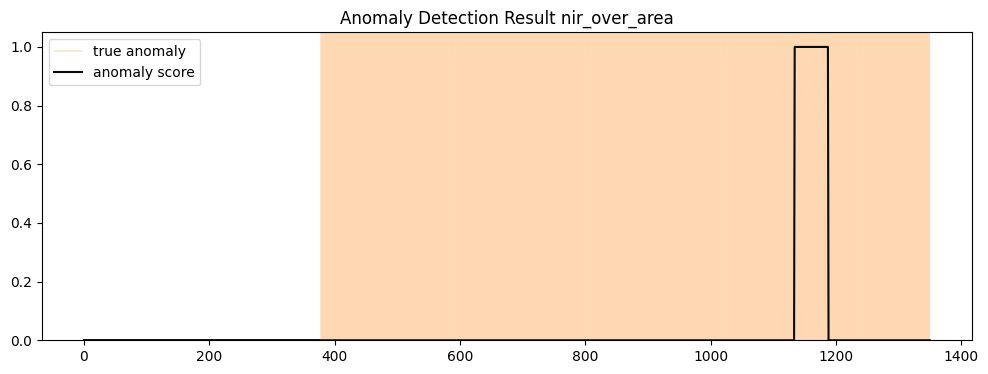

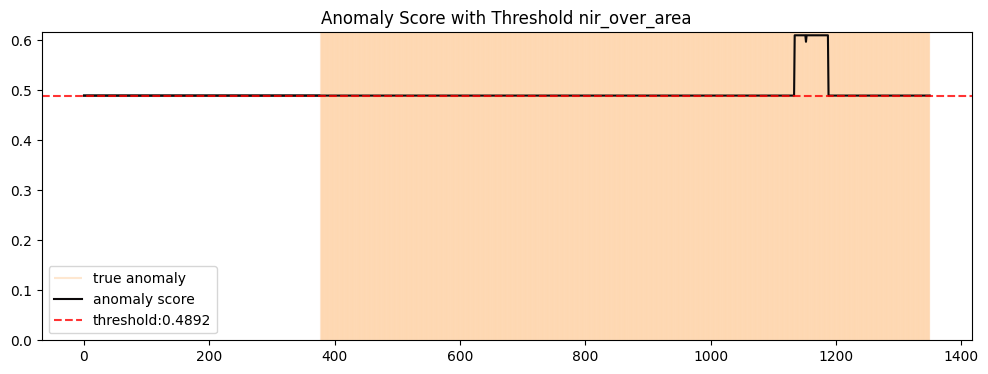

nir_extra_time
model Fitted
Inference Completed
Confusion Matrix: (335, 43, 610, 362)


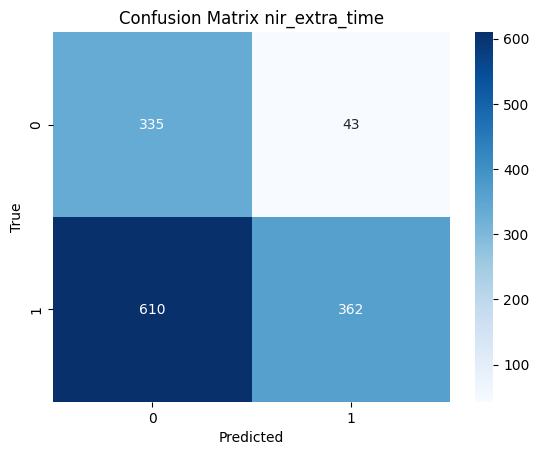

AUROC: 0.6857, F1: 0.8120, Precision: 0.7354, Recall: 0.9064
[{1: 13, 0: 41}, {0: 51, 1: 3}, {1: 4, 0: 50}, {0: 47, 1: 7}, {0: 48, 1: 6}, {0: 48, 1: 6}, {0: 50, 1: 4}, {1: 52, 0: 2}, {0: 28, 1: 26}, {0: 48, 1: 6}, {0: 35, 1: 19}, {0: 47, 1: 7}, {1: 16, 0: 38}, {0: 36, 1: 18}, {0: 42, 1: 12}, {1: 32, 0: 22}, {1: 44, 0: 10}, {1: 31, 0: 23}, {0: 31, 1: 23}, {0: 46, 1: 8}, {0: 45, 1: 9}, {1: 37, 0: 17}, {0: 45, 1: 9}, {0: 50, 1: 4}, {0: 45, 1: 9}]


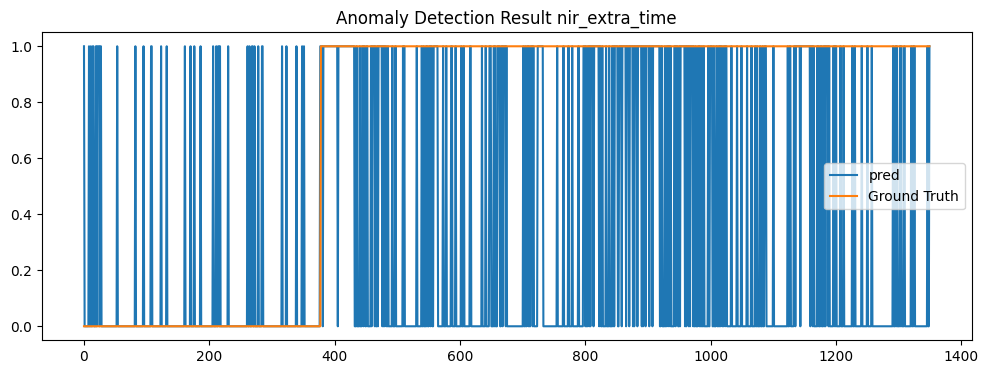

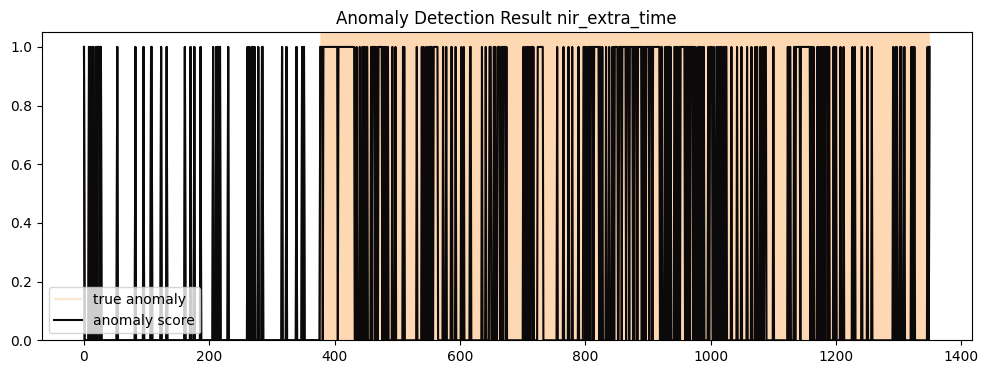

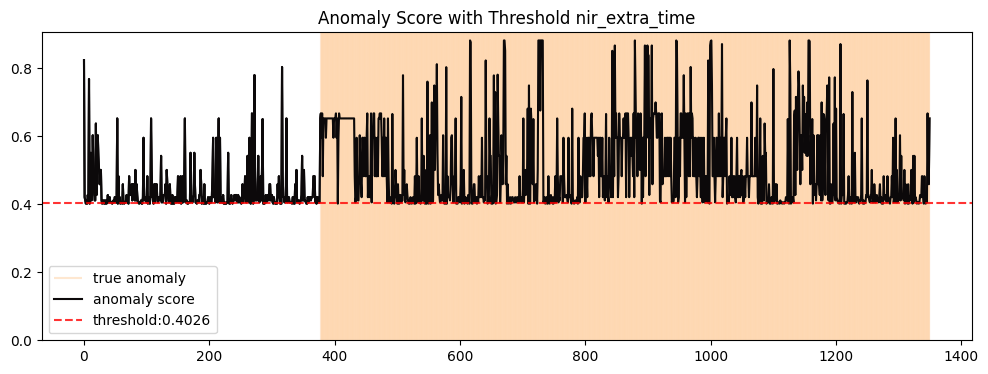

nir_extra_area
model Fitted
Inference Completed
Confusion Matrix: (332, 46, 563, 409)


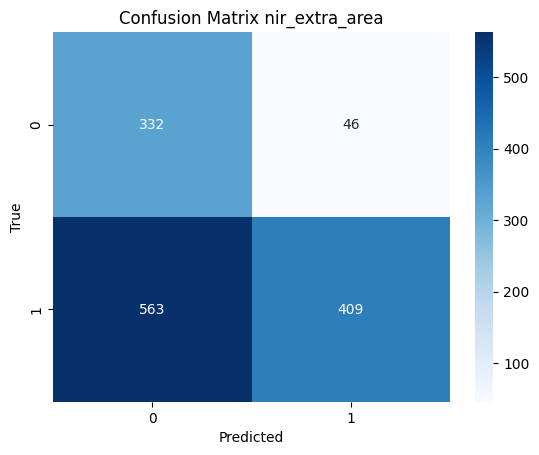

AUROC: 0.6971, F1: 0.8367, Precision: 0.7198, Recall: 0.9990
[{1: 10, 0: 44}, {0: 46, 1: 8}, {0: 49, 1: 5}, {0: 48, 1: 6}, {0: 48, 1: 6}, {0: 45, 1: 9}, {0: 52, 1: 2}, {1: 52, 0: 2}, {0: 24, 1: 30}, {0: 47, 1: 7}, {0: 35, 1: 19}, {0: 44, 1: 10}, {0: 40, 1: 14}, {0: 41, 1: 13}, {1: 20, 0: 34}, {1: 34, 0: 20}, {1: 41, 0: 13}, {1: 41, 0: 13}, {0: 23, 1: 31}, {0: 43, 1: 11}, {0: 45, 1: 9}, {1: 52, 0: 2}, {0: 43, 1: 11}, {0: 48, 1: 6}, {0: 46, 1: 8}]


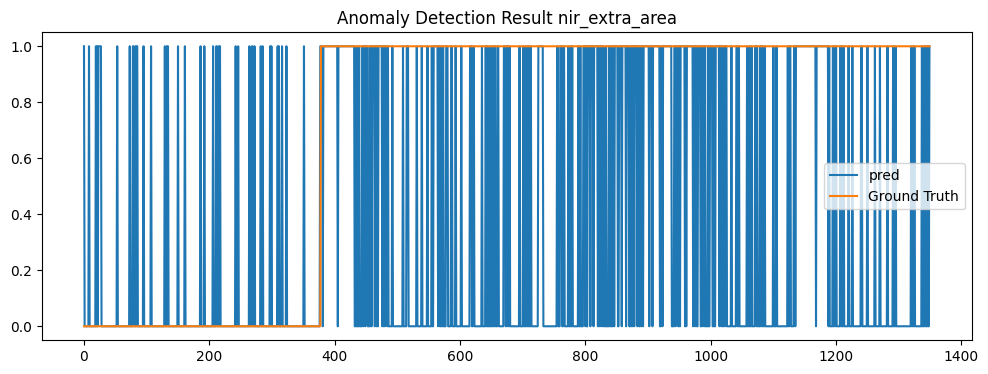

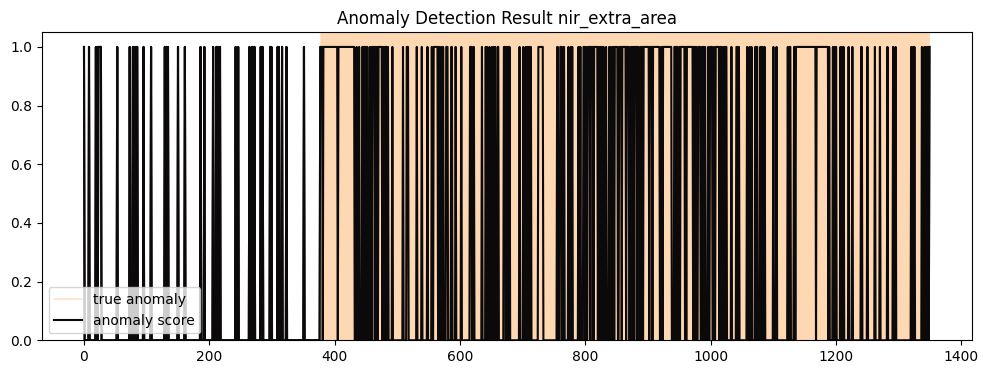

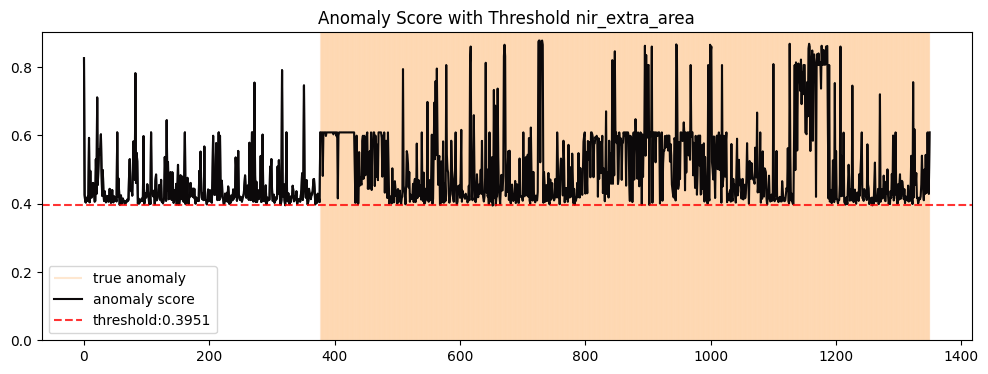

nir_sum_area
model Fitted
Inference Completed
Confusion Matrix: (304, 74, 334, 638)


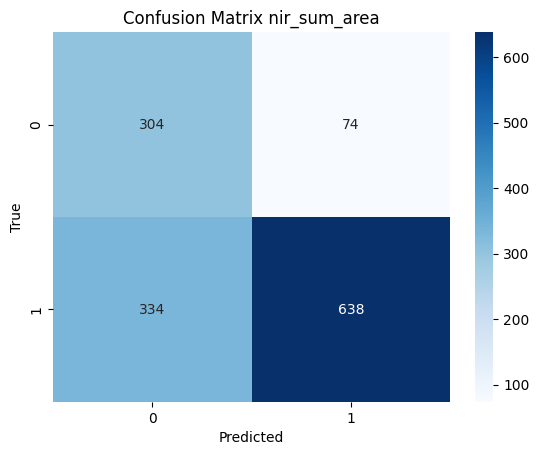

AUROC: 0.7922, F1: 0.8394, Precision: 0.7490, Recall: 0.9547
[{1: 7, 0: 47}, {0: 41, 1: 13}, {1: 9, 0: 45}, {0: 41, 1: 13}, {0: 44, 1: 10}, {1: 11, 0: 43}, {0: 43, 1: 11}, {1: 54}, {1: 49, 0: 5}, {1: 42, 0: 12}, {1: 53, 0: 1}, {0: 40, 1: 14}, {1: 19, 0: 35}, {0: 20, 1: 34}, {0: 27, 1: 27}, {0: 21, 1: 33}, {1: 32, 0: 22}, {0: 24, 1: 30}, {1: 51, 0: 3}, {1: 51, 0: 3}, {1: 54}, {1: 54}, {0: 36, 1: 18}, {0: 42, 1: 12}, {0: 43, 1: 11}]


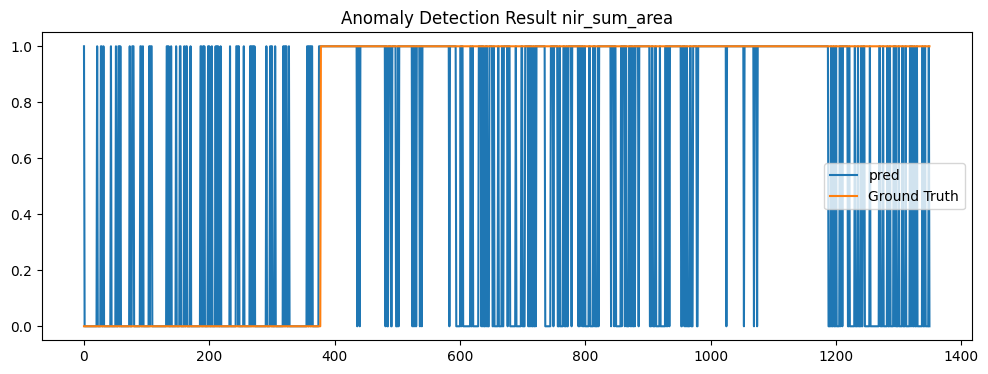

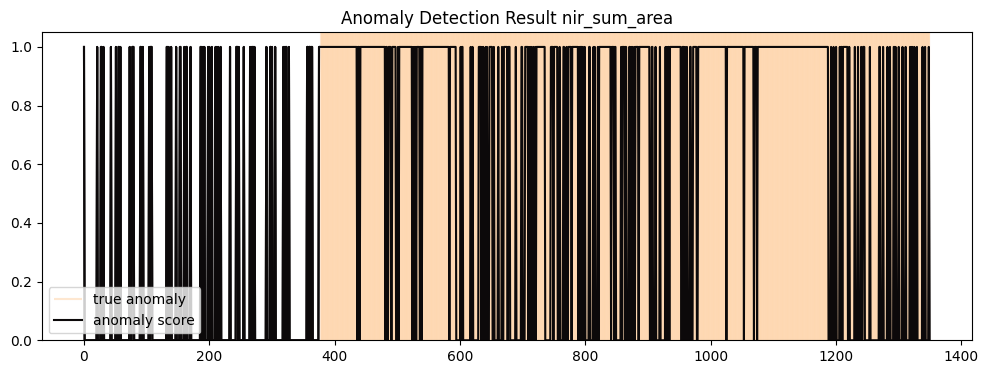

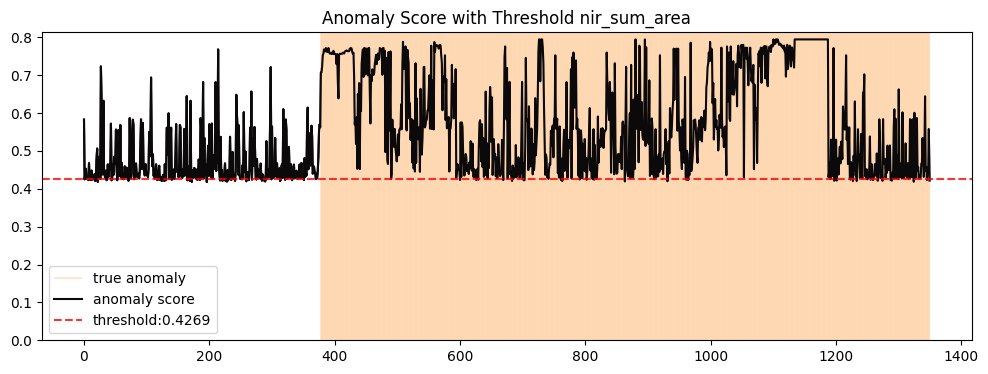

lo_height_mean
model Fitted
Inference Completed
Confusion Matrix: (289, 89, 0, 972)


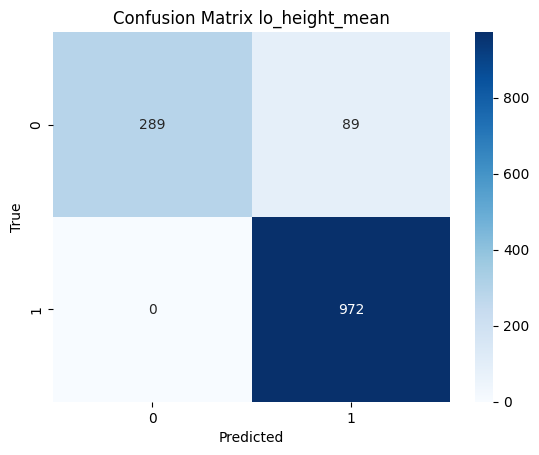

AUROC: 0.9989, F1: 0.9933, Precision: 0.9948, Recall: 0.9918
[{0: 43, 1: 11}, {0: 29, 1: 25}, {0: 44, 1: 10}, {0: 46, 1: 8}, {0: 48, 1: 6}, {0: 39, 1: 15}, {0: 40, 1: 14}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}]


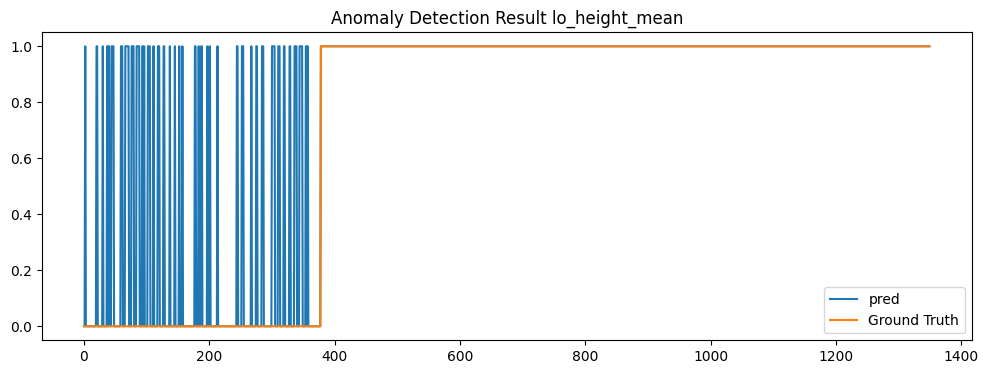

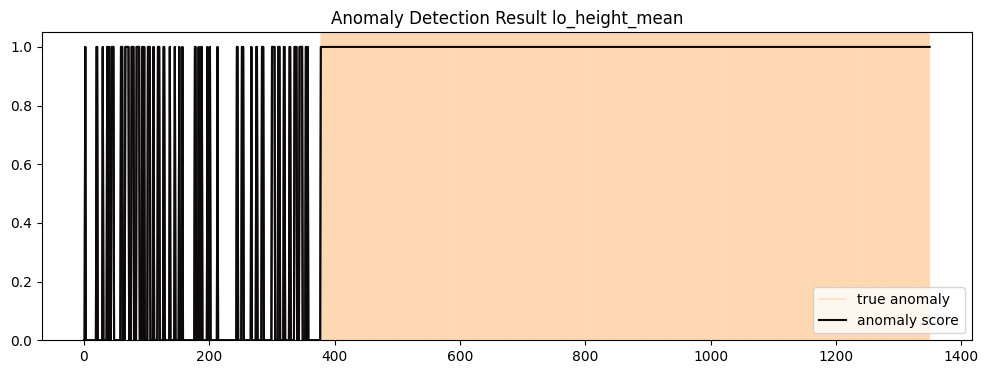

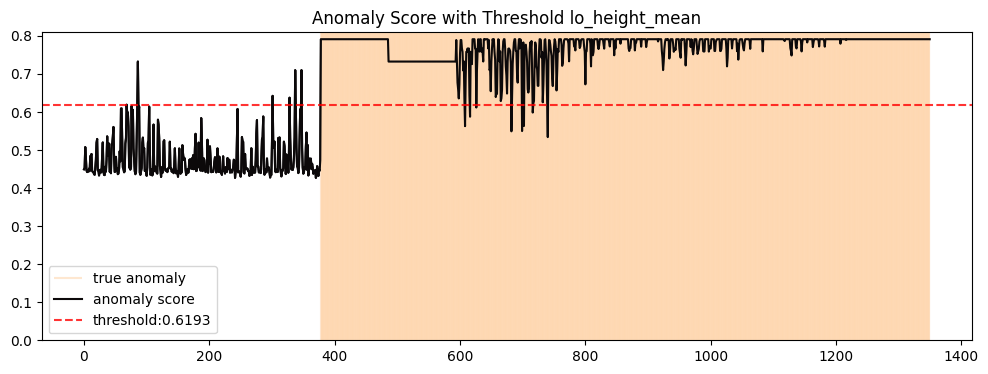

lo_area
model Fitted
Inference Completed
Confusion Matrix: (290, 88, 275, 697)


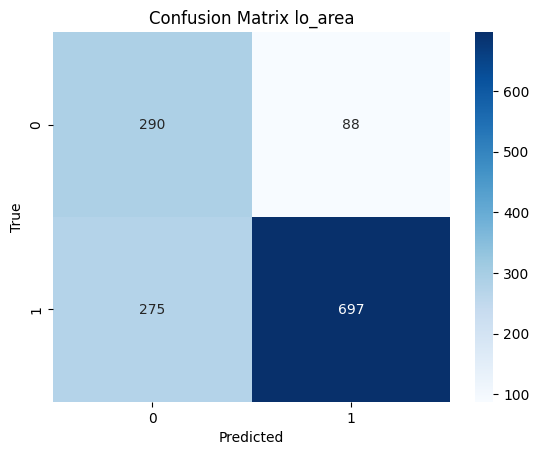

AUROC: 0.8486, F1: 0.8675, Precision: 0.8319, Recall: 0.9064
[{0: 22, 1: 32}, {0: 51, 1: 3}, {0: 50, 1: 4}, {0: 54}, {0: 48, 1: 6}, {0: 21, 1: 33}, {0: 44, 1: 10}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 54}, {1: 9, 0: 45}, {1: 15, 0: 39}, {0: 44, 1: 10}, {1: 32, 0: 22}, {1: 52, 0: 2}, {0: 18, 1: 36}, {1: 25, 0: 29}, {0: 39, 1: 15}, {1: 54}, {0: 34, 1: 20}, {1: 51, 0: 3}]


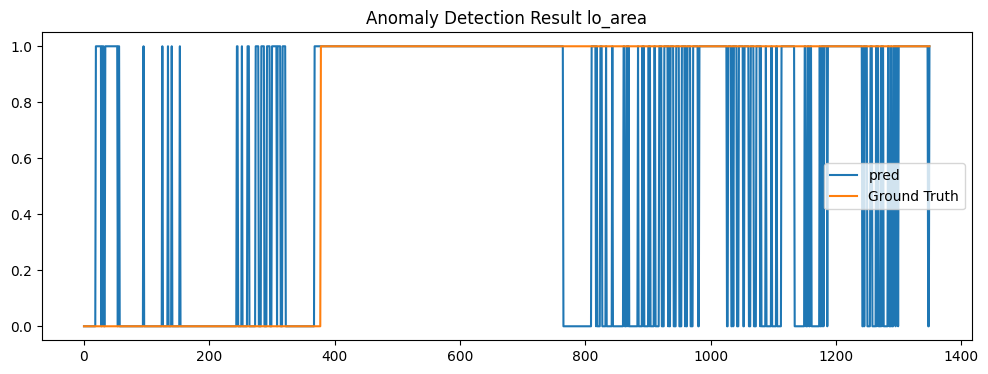

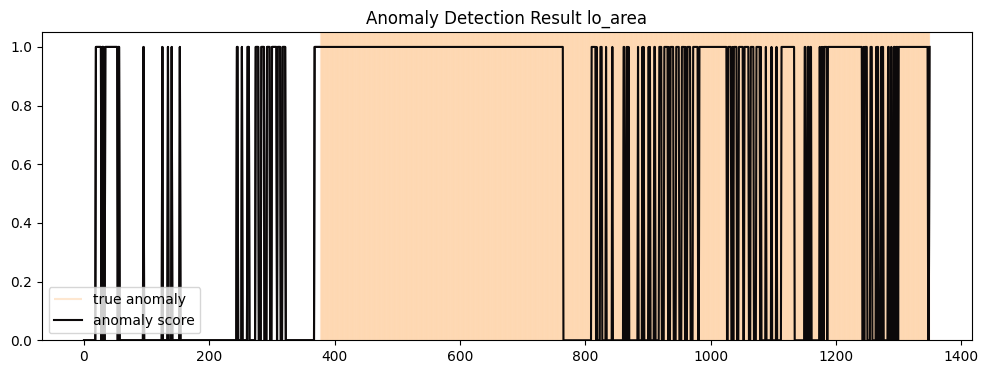

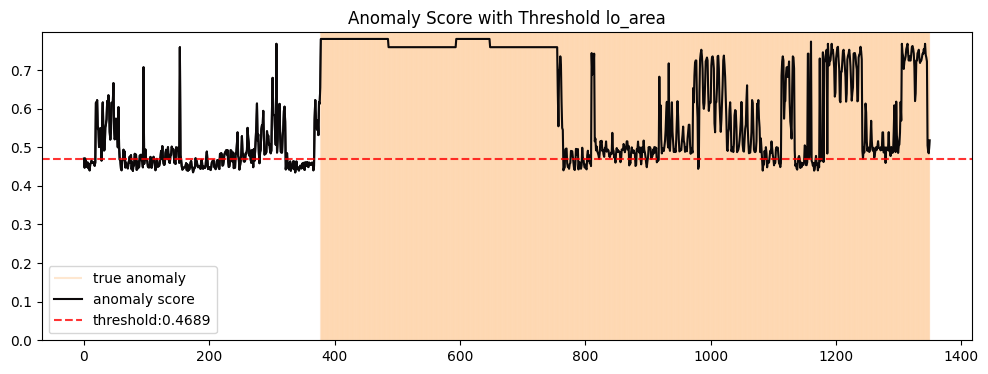

vis_peak
model Fitted
Inference Completed
Confusion Matrix: (312, 66, 438, 534)


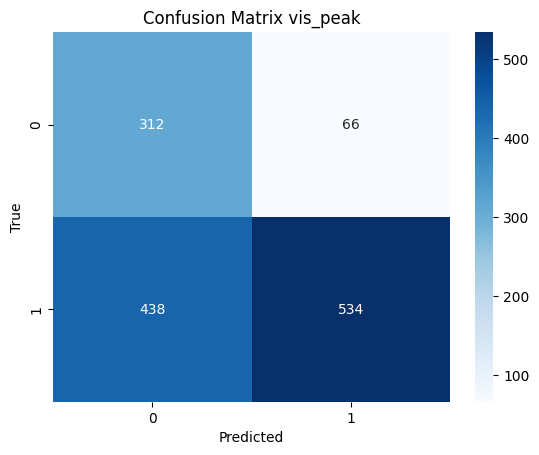

AUROC: 0.7210, F1: 0.8376, Precision: 0.7233, Recall: 0.9949
[{0: 38, 1: 16}, {0: 46, 1: 8}, {1: 6, 0: 48}, {1: 12, 0: 42}, {0: 47, 1: 7}, {0: 46, 1: 8}, {0: 45, 1: 9}, {1: 54}, {0: 4, 1: 50}, {0: 44, 1: 10}, {1: 27, 0: 27}, {0: 35, 1: 19}, {1: 16, 0: 38}, {0: 44, 1: 10}, {1: 12, 0: 42}, {1: 33, 0: 21}, {1: 44, 0: 10}, {1: 45, 0: 9}, {1: 47, 0: 7}, {1: 38, 0: 16}, {0: 46, 1: 8}, {1: 54}, {1: 21, 0: 33}, {0: 27, 1: 27}, {1: 19, 0: 35}]


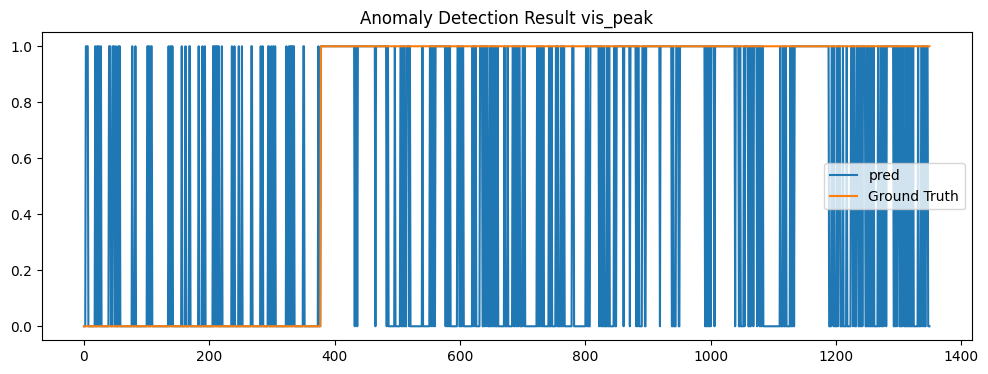

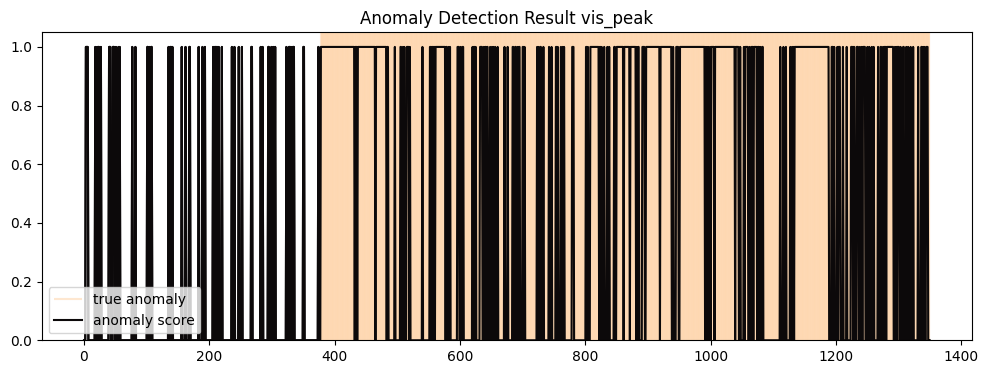

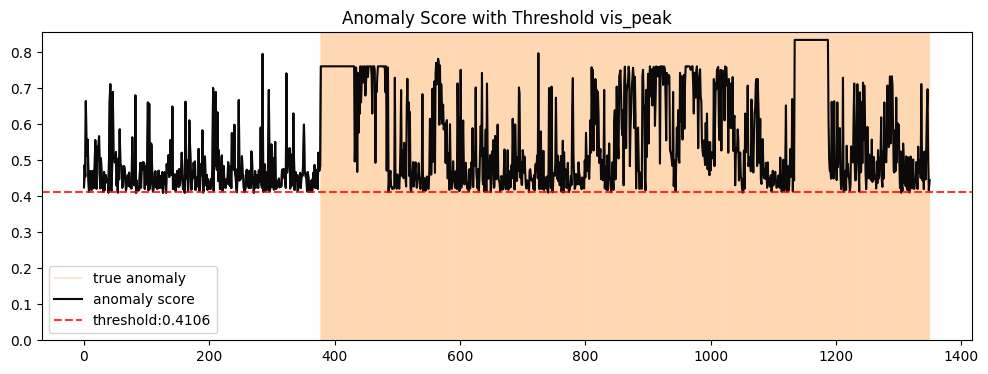

In [26]:
df_metrics = pd.DataFrame()
df_bead_counter = pd.DataFrame()

for idx, name in enumerate(selected_features):

    print(name)

    IF = modelling_nir(model, dataset, name, random_state = 72)

    IF.fit()

    confusion_mat = IF.get_confusion_mat()

    metrics_ = IF.get_metrics()

    temp = pd.DataFrame(metrics_.values()).T
    temp.columns = list(metrics_.keys())

    df_metrics = pd.concat([df_metrics, temp], axis = 0)

    bead_counter_ = IF.bead_count()
    
    temp_df = pd.DataFrame(bead_counter_).fillna(0)
    temp_df['feature_name'] = name

    df_bead_counter = pd.concat([df_bead_counter, temp_df], axis = 0)


    IF.plot_result()

df_metrics.index = selected_features
df_metrics = df_metrics.T
df_bead_counter = df_bead_counter[['feature_name', 0, 1]]
df_bead_counter.columns = ['feature_name', 'Normal', 'Abnormal']

In [27]:
df_bead_counter

,feature_name,Normal,Abnormal
0,nir_peak,40.0,14.0
1,nir_peak,45.0,9.0
2,nir_peak,46.0,8.0
3,nir_peak,45.0,9.0
4,nir_peak,49.0,5.0
...,...,...,...
20,vis_peak,46.0,8.0
21,vis_peak,0.0,54.0
22,vis_peak,33.0,21.0
23,vis_peak,27.0,27.0


In [29]:
df_metrics

,nir_peak,nir_reach_time,nir_over_area,nir_extra_time,nir_extra_area,nir_sum_area,lo_height_mean,lo_area,vis_peak
AUROC,0.621249,0.750542,0.527778,0.685710,0.697094,0.792151,0.998933,0.848606,0.720982
F1,0.836703,0.836025,0.105262,0.811977,0.836703,0.839434,0.993297,0.867548,0.837587
Precision,0.719792,0.726996,1.000000,0.735392,0.719792,0.748991,0.994840,0.831917,0.723261
Recall,0.998971,0.983539,0.055556,0.906379,0.998971,0.954733,0.991770,0.906379,0.994856
